###  Import libraries


In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from tensorflow import keras
from zipfile import ZipFile
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### Hiperparámetros

In [2]:
csv_path          = "regina.csv"
predicted_feature = 'Temp Out'
dropped_features  = ['Hi Temp', 'Low Temp', 'Wind Chill', 'Heat Index', 'THSW Index', 'THW Index', 'Wind Run', 'Solar Energy', 'Hi Solar Rad.', 'In Heat', 'ISS Recept', 'Arc. Int']

train_perc = .7
val_perc   = .2

sequence_length = 48
offset          = 5
sampling_rate   = 3
length          = 6 #horas
min_temp        = 0
batch_size      = 256

learning_rate   = 0.001
epochs          = 10
loss            = "mse"

### Read CSV

In [3]:
dateparse = lambda x: datetime.strptime(x, '%d.%m.%y %H:%M')

data = pd.read_csv(csv_path, parse_dates=['Date Time'], date_parser=dateparse, index_col=0)
data.head()

data = data.drop(['Wind Dir', 'Hi Dir'], axis = 1)

C:\Users\franc\miniconda3\envs\proyecto-final\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (1,2,3,4,5,11,12,13,14,15,18,19,20,21,22,23,24,25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
data.info()

data = data.replace('---', np.nan)
data = data.replace('------', np.nan)

for column in data:
    if (not column == 'Wind Dir' and not column == 'Hi Dir'):
        data[column] = pd.to_numeric(data[column])

data.info()

data.iloc[271020]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 606426 entries, 2010-01-28 14:20:00 to 2022-01-01 00:00:00
Data columns (total 29 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Temp Out       606426 non-null  object 
 1   Hi Temp        606426 non-null  object 
 2   Low Temp       606426 non-null  object 
 3   Out Hum        606426 non-null  object 
 4   Dew Pt.        606426 non-null  object 
 5   Wind Speed     606426 non-null  float64
 6   Wind Run       606426 non-null  float64
 7   Hi Speed       606426 non-null  float64
 8   Wind Chill     606426 non-null  object 
 9   Heat Index     606426 non-null  object 
 10  THW Index      606426 non-null  object 
 11  THSW Index     606426 non-null  object 
 12  Bar            606426 non-null  object 
 13  Rain           606426 non-null  float64
 14  Rain Rate      606426 non-null  float64
 15  Solar Rad.     606426 non-null  object 
 16  Solar Energy   606426 non-null  object 


Temp Out           NaN
Hi Temp            NaN
Low Temp           NaN
Out Hum            NaN
Dew Pt.            NaN
Wind Speed         0.0
Wind Run           0.0
Hi Speed           1.6
Wind Chill         NaN
Heat Index         NaN
THW Index          NaN
THSW Index         NaN
Bar              760.9
Rain               0.0
Rain Rate          0.0
Solar Rad.         0.0
Solar Energy       0.0
Hi Solar Rad.      0.0
Heat D-D           NaN
Cool D-D           NaN
In Temp           22.3
In Hum            50.0
In Dew            11.4
In Heat           21.8
ET                 0.0
Wind Samp        230.0
Wind Tx            1.0
ISS Recept       100.0
Arc. Int          10.0
Name: 2015-04-25 21:30:00, dtype: float64

### Agregamos los datos que faltan

In [5]:
newData = data.resample('10min', origin='start').interpolate()

In [6]:
newData.info()
newData.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 627179 entries, 2010-01-28 14:20:00 to 2022-01-01 00:00:00
Freq: 10T
Data columns (total 29 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Temp Out       627179 non-null  float64
 1   Hi Temp        627179 non-null  float64
 2   Low Temp       627179 non-null  float64
 3   Out Hum        627179 non-null  float64
 4   Dew Pt.        627179 non-null  float64
 5   Wind Speed     627179 non-null  float64
 6   Wind Run       627179 non-null  float64
 7   Hi Speed       627179 non-null  float64
 8   Wind Chill     627179 non-null  float64
 9   Heat Index     627179 non-null  float64
 10  THW Index      627179 non-null  float64
 11  THSW Index     622656 non-null  float64
 12  Bar            627179 non-null  float64
 13  Rain           627179 non-null  float64
 14  Rain Rate      627179 non-null  float64
 15  Solar Rad.     627179 non-null  float64
 16  Solar Energy   627179 non-null

,Temp Out,Hi Temp,Low Temp,Out Hum,Dew Pt.,Wind Speed,Wind Run,Hi Speed,Wind Chill,Heat Index,...,Cool D-D,In Temp,In Hum,In Dew,In Heat,ET,Wind Samp,Wind Tx,ISS Recept,Arc. Int
Date Time,,,,,,,,,,,,,,,,,,,,,
2010-01-28 14:20:00,32.9,33.1,32.9,21.0,7.7,0.0,0.00,0.0,32.9,31.2,...,0.101,33.0,21.0,7.8,31.2,0.00,227.0,1.0,99.6,10.0
2010-01-28 14:30:00,32.9,33.1,32.7,24.0,9.7,1.6,0.27,41.8,32.9,31.5,...,0.101,33.2,24.0,9.9,31.8,0.00,229.0,1.0,100.0,10.0
2010-01-28 14:40:00,30.6,32.6,28.7,28.0,10.0,0.0,0.00,22.5,30.6,29.4,...,0.085,32.1,26.0,10.1,30.7,0.00,228.0,1.0,100.0,10.0
2010-01-28 14:50:00,27.7,28.7,27.0,32.0,9.5,0.0,0.00,16.1,27.7,26.7,...,0.065,29.4,30.0,10.1,28.4,0.00,224.0,1.0,98.2,10.0
2010-01-28 15:00:00,26.4,26.9,25.9,33.0,8.8,0.0,0.00,16.1,26.4,25.5,...,0.056,28.3,30.0,9.1,27.2,0.33,227.0,1.0,99.6,10.0


### Convertimos estampillas de tiempo todo a segundos

In [7]:
timestamp_s = data.index
timestamp_s = timestamp_s.map(pd.Timestamp.timestamp)

day = 24*60*60
year = 365.2425 * day

data['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
data['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

## Correlación de los datos

In [8]:
data.corr()

,Temp Out,Hi Temp,Low Temp,Out Hum,Dew Pt.,Wind Speed,Wind Run,Hi Speed,Wind Chill,Heat Index,...,In Heat,ET,Wind Samp,Wind Tx,ISS Recept,Arc. Int,Day sin,Day cos,Year sin,Year cos
Temp Out,1.000000,0.999613,0.999334,-0.648901,0.641747,0.209545,0.210169,0.319591,0.998547,0.995716,...,0.785806,0.205573,0.073998,-0.003143,0.078310,NaN,-0.455077,-0.227635,0.086449,0.664834
Hi Temp,0.999613,1.000000,0.998458,-0.649417,0.641434,0.207857,0.208480,0.317843,0.998195,0.995427,...,0.786087,0.205396,0.073677,-0.003162,0.078086,NaN,-0.455123,-0.228477,0.086458,0.665412
Low Temp,0.999334,0.998458,1.000000,-0.647729,0.641420,0.210963,0.211587,0.321049,0.997859,0.995015,...,0.785052,0.205646,0.074221,-0.003153,0.078435,NaN,-0.454732,-0.226697,0.086424,0.663873
Out Hum,-0.648901,-0.649417,-0.647729,1.000000,0.142924,-0.413926,-0.414589,-0.519868,-0.638800,-0.591836,...,-0.334098,-0.202256,-0.036454,0.001627,-0.068251,NaN,0.469887,0.234235,0.210315,-0.292338
Dew Pt.,0.641747,0.641434,0.641420,0.142924,1.000000,-0.136029,-0.135830,-0.100746,0.649223,0.695110,...,0.695662,0.059172,0.049863,-0.002669,0.024392,NaN,-0.112891,-0.065430,0.326511,0.578760
Wind Speed,0.209545,0.207857,0.210963,-0.413926,-0.136029,1.000000,0.999991,0.918792,0.170606,0.180250,...,-0.003561,0.136506,0.026907,-0.001176,0.045139,NaN,-0.217967,-0.244458,-0.123711,-0.010316
Wind Run,0.210169,0.208480,0.211587,-0.414589,-0.135830,0.999991,1.000000,0.919199,0.171242,0.180866,...,-0.003322,0.136722,0.027005,-0.001179,0.045255,NaN,-0.218190,-0.245083,-0.123755,-0.010049
Hi Speed,0.319591,0.317843,0.321049,-0.519868,-0.100746,0.918792,0.919199,1.000000,0.287298,0.287791,...,0.085611,0.160579,0.063346,-0.001555,0.074608,NaN,-0.244327,-0.274406,-0.124235,0.088633
Wind Chill,0.998547,0.998195,0.997859,-0.638800,0.649223,0.170606,0.171242,0.287298,1.000000,0.995104,...,0.789304,0.202385,0.074744,-0.003088,0.077979,NaN,-0.449358,-0.220270,0.091544,0.669626
Heat Index,0.995716,0.995427,0.995015,-0.591836,0.695110,0.180250,0.180866,0.287791,0.995104,1.000000,...,0.818232,0.201834,0.078050,-0.003188,0.080049,NaN,-0.445688,-0.223981,0.118522,0.683355


## Dropeamos las características que no tienen correlación

In [9]:
df = newData.drop(dropped_features, axis = 1)

predicted_feature = df.columns.get_loc(predicted_feature)

### Normalización de los datos

In [10]:
df_length = len(df)

train_length = int(df_length*train_perc)
val_length   = int(df_length*(train_perc+val_perc))

train_mean = df.values[:train_length].mean(axis=0)
train_std  = df.values[:train_length].std(axis=0)

df_norm = (df.values - train_mean) / train_std
df_norm = pd.DataFrame(df_norm)

### Dividimos los datos


In [11]:
train_df = df_norm[:train_length-1]
val_df   = df_norm[train_length:val_length-1]
test_df_norm  = df_norm[val_length:]
#test_df       = df[val_length:]

###  Create datasets


In [12]:
def create_y_lento(df_norm, start, end, length, min_temp):
    y_data = []
    
    for i in range(start, end):
        freeze = 0
        for j in range(i, i+length):
            if df_norm.iloc[j][predicted_feature] <= min_temp:
                freeze = 1
                break
        y_data.append(freeze)

    return y_data

In [13]:
def create_y(df, start, end, length, min_temp):
    y_data = np.arange(end-start)
    
    df_bool = df['Temp Out'][start:end] <= min_temp
    
    for i in range(0, end-start):
        y_data[i] = 1 if np.any(df_bool[i:i+length]) else 0

    return y_data

In [14]:
start = sequence_length*sampling_rate + offset*sampling_rate
end   = train_length + offset*sampling_rate

x_train = train_df
y_train = create_y(df, start, end, length*6, min_temp)
#df_norm[[predicted_feature]][start:end]

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train.values,
    y_train,
    sequence_length = sequence_length,
    sampling_rate = sampling_rate,
    shuffle=True,
    batch_size = batch_size
)

In [15]:
print((end-start))
tf.data.experimental.cardinality(dataset_train)
print(dataset_train)

print(y_train)

for x, y in dataset_train.take(1):
    print(x[0][0])
    print(y)

438881
<BatchDataset shapes: ((None, None, 17), (None,)), types: (tf.float64, tf.int32)>
[0 0 0 ... 0 0 0]
tf.Tensor(
[-0.67446918  1.57090472  0.32788023 -0.69084276 -0.90105163 -0.02064445
  0.28764345  0.16434625 -0.62662167  0.59845288 -0.53807478 -0.87539166
  0.96110237 -0.40598446 -0.25620901  0.3626362  -0.00213438], shape=(17,), dtype=float64)
tf.Tensor(
[1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0], shape=(256,), dtype=int32)


In [16]:
start = train_length + sequence_length*sampling_rate + offset*sampling_rate
end   = val_length + offset*sampling_rate

x_val = val_df
y_val = create_y(df, start, end, length*6, min_temp)
#df_norm[[predicted_feature]][start:end]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val.values,
    y_val,
    sequence_length = sequence_length,
    sampling_rate = sampling_rate,
    shuffle=False,
    batch_size = batch_size
)

In [17]:
print(y_val)

for x, y in dataset_val.take(5):
    print(y)

[0 0 0 ... 0 0 0]
tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(256,), dtype=int32)
tf.Tensor(
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [18]:
start = val_length + sequence_length*sampling_rate + offset*sampling_rate
x_end = len(test_df_norm) - sequence_length*sampling_rate - offset*sampling_rate

x_test = test_df_norm[:x_end]
y_test = create_y(df, start, len(df_norm), length*6, min_temp)#df_norm[[predicted_feature]][start:]

dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    x_test.values,
    y_test,
    sequence_length = sequence_length,
    sequence_stride = sampling_rate,
    sampling_rate = sampling_rate,
    shuffle=False,
    batch_size = batch_size
)

In [19]:
print(y_test)

for x, y in dataset_test.take(5):
    print(y)

[0 0 0 ... 0 0 0]
tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(256,), dtype=int32)
tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

### Creamos el modelo


In [20]:
for batch in dataset_train.take(1):
    x, y = batch
    
input_shape = x.shape[1], x.shape[2]

In [21]:
inputs = keras.layers.Input(input_shape)
lstm_layer = keras.layers.LSTM(32, return_sequences=True)(inputs)
lstm_layer2 = keras.layers.LSTM(32)(lstm_layer)
output = keras.layers.Dense(1, activation="sigmoid")(lstm_layer2)

model = keras.Model(inputs, output)
model.compile(keras.optimizers.Adam(learning_rate), loss)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 17)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 48, 32)            6400      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 14,753
Trainable params: 14,753
Non-trainable params: 0
_________________________________________________________________


### Entrenamos el modelo

In [22]:
path_checkpoint = "model_test_regina.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_best_only=True,
)

history = model.fit(dataset_train, epochs = epochs, validation_data=dataset_val, callbacks = [es_callback, modelckpt_callback])

Epoch 1/10
1715/1715 [==============================] - 82s 46ms/step - loss: 0.0375 - val_loss: 0.0448

Epoch 00001: val_loss improved from inf to 0.04478, saving model to model_test_regina.h5
Epoch 2/10
1715/1715 [==============================] - 78s 45ms/step - loss: 0.0260 - val_loss: 0.0501

Epoch 00002: val_loss did not improve from 0.04478
Epoch 3/10
1715/1715 [==============================] - 80s 46ms/step - loss: 0.0202 - val_loss: 0.0554

Epoch 00003: val_loss did not improve from 0.04478
Epoch 4/10
1715/1715 [==============================] - 88s 51ms/step - loss: 0.0157 - val_loss: 0.0617

Epoch 00004: val_loss did not improve from 0.04478
Epoch 5/10
1715/1715 [==============================] - 85s 50ms/step - loss: 0.0131 - val_loss: 0.0638

Epoch 00005: val_loss did not improve from 0.04478
Epoch 6/10
1715/1715 [==============================] - 88s 51ms/step - loss: 0.0117 - val_loss: 0.0629

Epoch 00006: val_loss did not improve from 0.04478


In [23]:
for batch in dataset_train.take(1):
    x, y = batch
    
print(x.shape)

(256, 48, 17)


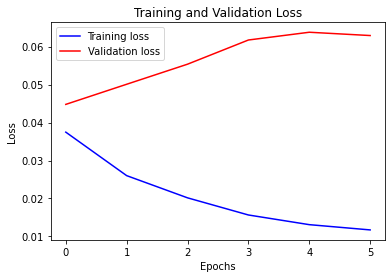

In [24]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

### Mostramos los resultados

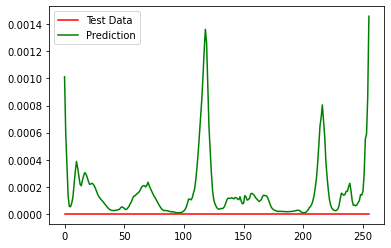

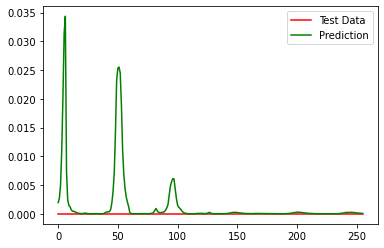

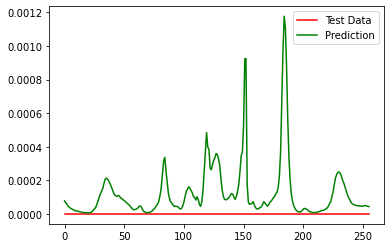

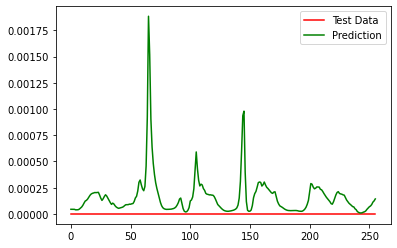

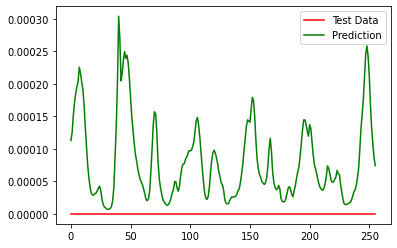

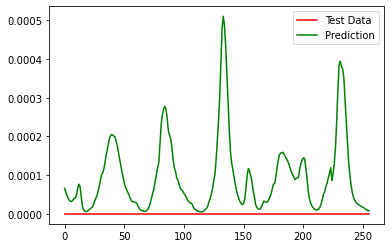

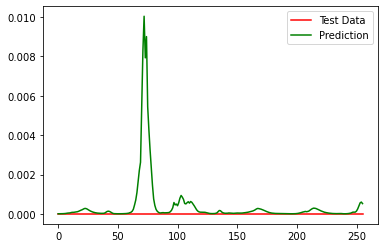

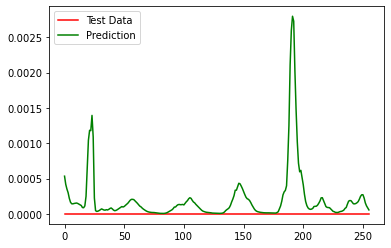

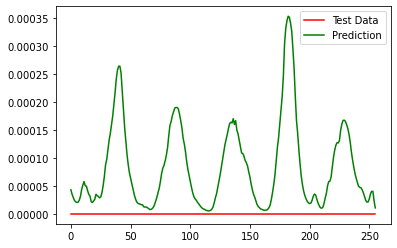

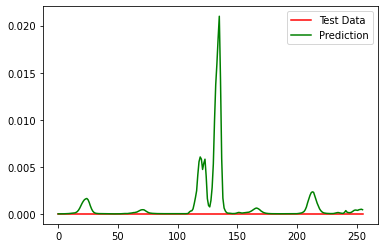

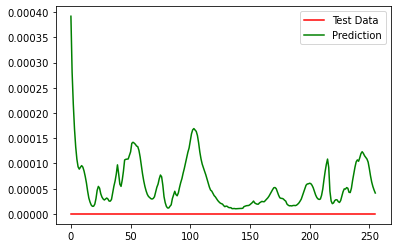

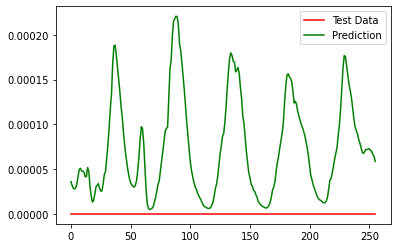

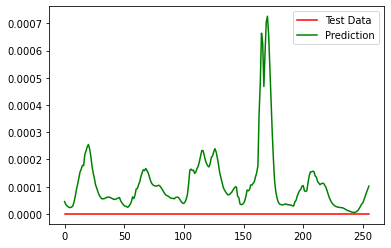

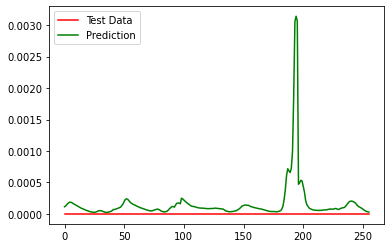

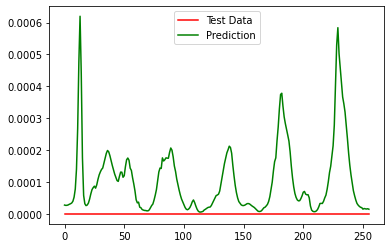

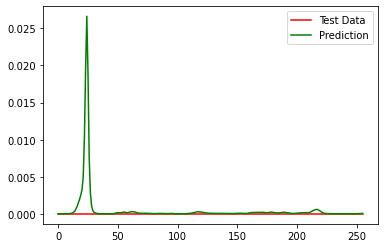

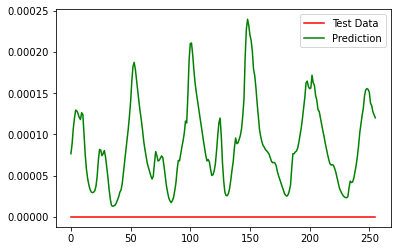

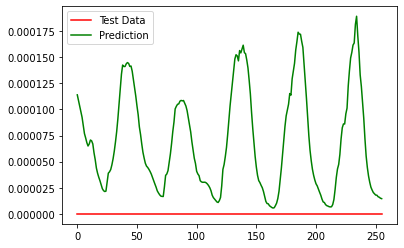

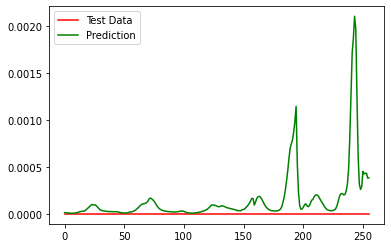

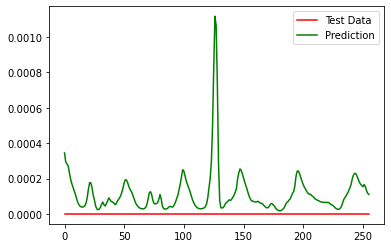

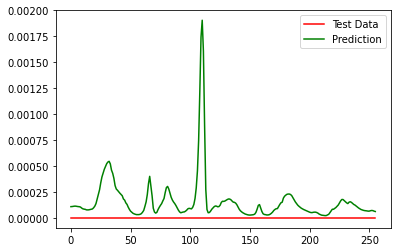

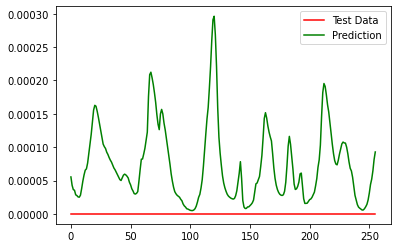

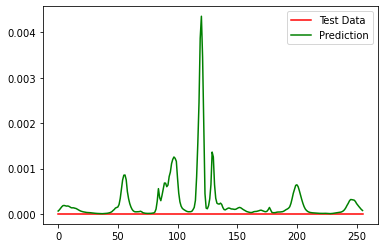

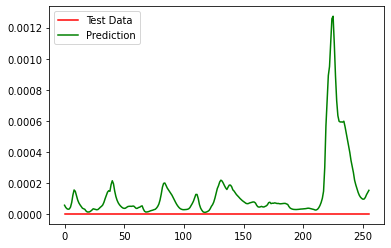

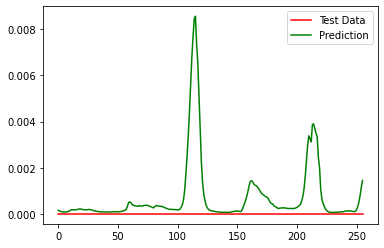

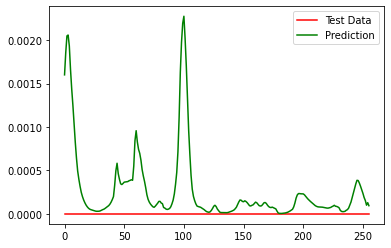

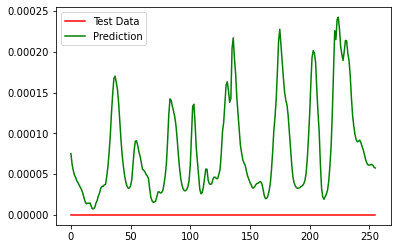

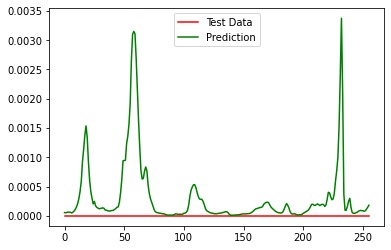

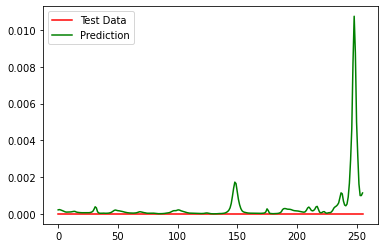

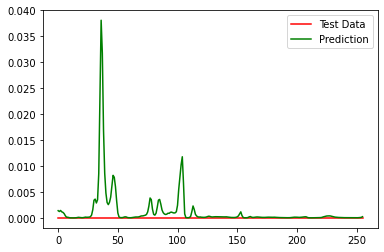

In [25]:
for batch in dataset_test.take(30):
    x, y = batch
    y_pred = model.predict(x)

    #y_pred = y_pred * train_std[predicted_feature] + train_mean[predicted_feature]
    #y = y * train_std[predicted_feature] + train_mean[predicted_feature]
    
    fig, ax = plt.subplots()
    
    ax.plot(y[0:100000], c='r', label="Test Data")
    ax.plot(y_pred[0:100000],c='g', label="Prediction")
    plt.legend()
    plt.show()

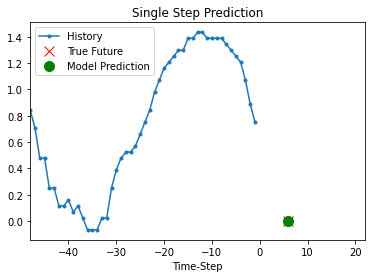

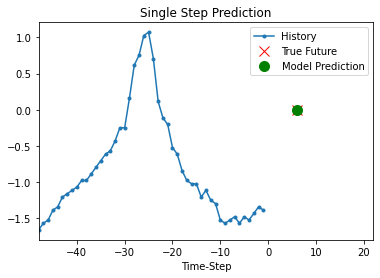

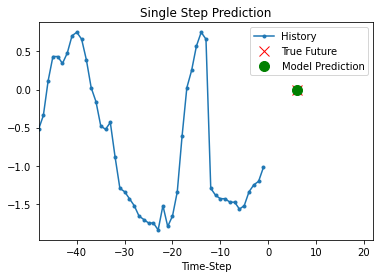

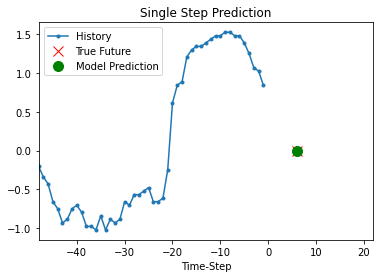

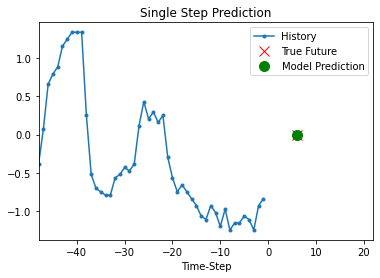

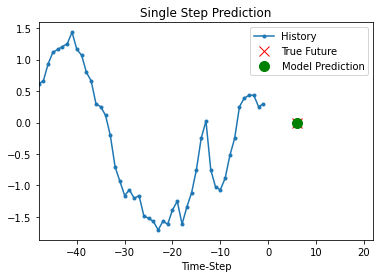

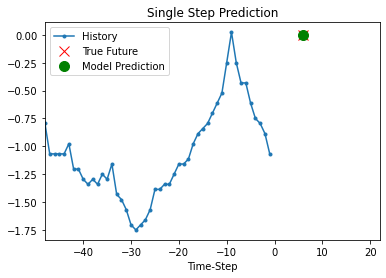

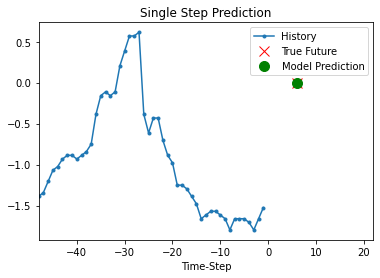

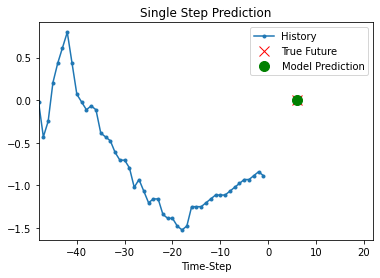

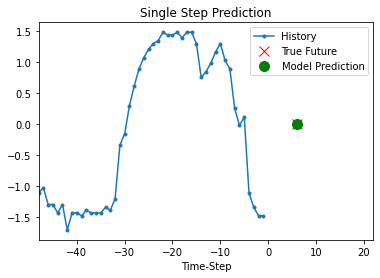

In [26]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x1, y1 in dataset_test.take(10):
    show_plot(
        [x1[0][:, 1].numpy(), y1[0].numpy(), model.predict(x1)[0]],
        6,
        "Single Step Prediction",
    )